# Still Can't Decide Between Modules and Jupyter

## Libraries

In [1]:
#%% Libraries
# # Standard Libraries
from pprint import pprint

# External Libraries
from IPython.display import display
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
from sklearn.linear_model import BayesianRidge as BR
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.ensemble import RandomForestRegressor as RFR
import matplotlib.pylab as mlt

# Custom Libraries
from modules.shared.custom import split, getPI, validate, Models

## Collection

In [2]:
# Just getting datasets
dataRoute = '../data/chembl/Additional_datasets/'
paths = ['data_CHEMBL313.csv', 'data_CHEMBL2637.csv', 'data_CHEMBL4124.csv']
dataSets = [pd.read_csv(dataRoute + path) for path in paths]
data = dataSets[2].sample(frac=1, random_state=1)
display(data)

,molecule_id,pXC50,b0001,b0002,b0003,b0004,b0005,b0006,b0007,b0008,...,b1015,b1016,b1017,b1018,b1019,b1020,b1021,b1022,b1023,b1024
108,CHEMBL1085591,7.770,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1339,CHEMBL488248,7.921,1,0,1,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
258,CHEMBL129198,5.860,1,0,1,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
982,CHEMBL282903,7.860,1,0,1,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
288,CHEMBL14811,8.456,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,CHEMBL2013052,8.222,1,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
905,CHEMBL270011,10.326,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1096,CHEMBL345808,7.374,1,1,1,0,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
235,CHEMBL1277594,8.284,1,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [19]:
def reduceTree(std: np.ndarray, X_unknown: pd.DataFrame, r: int):
    tree = KDTree(X_unknown.values)
    indicies = tree.query_ball_point(np.array(X_unknown), r, workers=-1)
    sdev = [std[i] for i in indicies]
    sdevMax = [max(s) for s in sdev]
    print(f" tree {len(np.where(sdevMax == std)[0])}")
    return np.where(sdevMax == std)[0]

## Models and Basics Set-up

In [20]:
# Splitting up the data
X_known, Y_known, X_unknown, Y_unknown, X_test, Y_test = split(data, 160)

# Each testing stage can test 160 cases and up to 2000 samples will be tested
testSize = 160
maxSamples = len(Y_unknown)

# models to be used and pre-defining variables
models = Models([BR(), KNN(n_jobs=-1), RFR(random_state=1)])
predicitions: list
scores: list
smartScores: list
tree: KDTree

## Assessment

## Script

In [21]:
r = 4
runningScore = []
for i in range(0, maxSamples, testSize):
    print(f'\r{i}.1 out of {maxSamples}', end="")

    models.fit(X_known, Y_known)
    pred, err = models.predict_error(X_unknown)
##########################################Prove#################################################
    index = reduceTree(err, X_unknown, r)
    if len(index)>min(160, len(X_unknown)):
        index = index[:min(160, len(X_unknown))]

    else:
        semi = np.argpartition(err, -min(len(X_unknown), testSize))[-min(len(X_unknown), testSize):]
        semi = semi[np.invert(np.isin(semi, index))]
        index = np.array(list(index) + list((semi[np.argsort(err[semi])])[len(index)-min(len(X_unknown), testSize):]))

    print(f'\r{i}.5 out of {maxSamples}', end="")
    score = validate(Y_test, models.predict(X_test))
    runningScore.append(score)
    
    index2 = X_unknown.iloc[index[:min(testSize, len(X_unknown))]].index
    X_known, Y_known, X_unknown, Y_unknown = getPI((X_known, Y_known), (X_unknown, Y_unknown), index2[:testSize])   
##############################################################################################

0.1 out of 1294 tree 169
160.1 out of 1294 tree 111
320.1 out of 1294 tree 90
480.1 out of 1294 tree 74
640.1 out of 1294 tree 66
800.1 out of 1294 tree 58
960.1 out of 1294 tree 48
1120.1 out of 1294 tree 36
1280.1 out of 1294 tree 10
1280.5 out of 1294

In [22]:
# import matplotlib.pyplot as plt
# temp = np.array(data.drop(columns=["pXC50", "molecule_id"]))*np.array(data["pXC50"])

# plt.imshow(np.transpose(temp))


## Baseline

In [23]:
X_known, Y_known, X_unknown, Y_unknown, X_test, Y_test = split(data, 160)

runningScore2 = []
for i in range(0, maxSamples, testSize):
    print(f'\r{i}.2 out of {maxSamples}', end="")

    models.fit(X_known, Y_known)
        
    index2 = X_unknown.iloc[:min(testSize, len(X_unknown))].index
    score = validate(Y_test, models.predict(X_test))
    runningScore2.append(score)
    X_known, Y_known, X_unknown, Y_unknown = getPI((X_known, Y_known), (X_unknown, Y_unknown), index2[:testSize])

1280.2 out of 1294

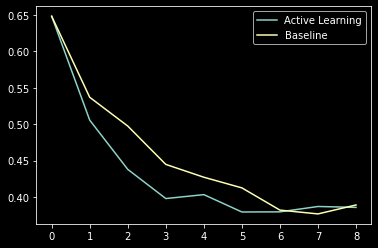

In [24]:
mlt.plot(runningScore, label="Active Learning")
mlt.plot(runningScore2, label="Baseline")
mlt.legend()